In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from cartopy import feature as cfeature

# Original data (torch tensor)
lat = torch.linspace(-90, 90, steps=10)  # 10 latitude points
lon = torch.linspace(0, 360, steps=20)  # 20 longitude points

# Create a grid of values (for demonstration, we'll use a simple mesh grid)
x, y = torch.meshgrid(lat, lon)
z = torch.sin(torch.deg2rad(x)) * torch.cos(torch.deg2rad(y)) + torch.exp(
    -torch.deg2rad(y)
)

# Reshape z to be 4D: (batch, channels, height, width)
z = z.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions

# Define padding amounts
pad_lat = 2  # Padding for latitude (reflective padding)
pad_lon = 2  # Padding for longitude (circular padding)


# Circular padding for longitude (wrap around)
def circular_pad1d(x, pad):
    return torch.cat([x[..., -pad:], x, x[..., :pad]], dim=-1)


# Step 1: Rotate the tensor by 180 degrees along the longitude axis to introduce the shift
z = torch.roll(
    z, shifts=z.shape[1] // 2, dims=1
)  # 180-degree shift (half the longitude size)

# Step 2: Apply circular padding for the longitudinal dimension
z_padded = circular_pad1d(z, pad=pad_lon)

# Step 3: Apply reflective padding for the latitudinal dimension
z_padded = F.pad(z_padded, (0, 0, pad_lat, pad_lat), mode="reflect")

# Remove batch and channel dimensions for visualization
z_padded = z_padded.squeeze(0).squeeze(0)

# Original lat/lon values
lat_step = lat[1] - lat[0]  # Get latitude step size
lon_step = lon[1] - lon[0]  # Get longitude step size

# Adjust padded latitude and longitude ranges
padded_lat = torch.linspace(
    lat[0] - pad_lat * lat_step, lat[-1] + pad_lat * lat_step, steps=z_padded.shape[0]
)
padded_lon = torch.linspace(
    lon[0] - pad_lon * lon_step, lon[-1] + pad_lon * lon_step, steps=z_padded.shape[1]
)

/glade/work/wchapman/conda-envs/credit/lib/python3.11/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


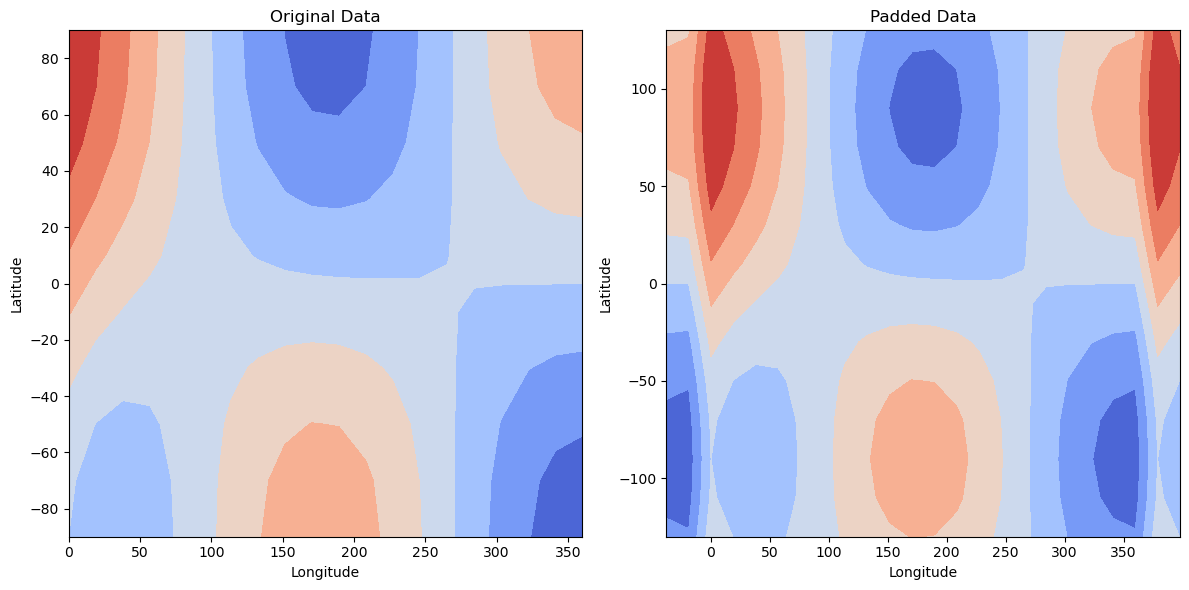

In [2]:
# Plot the original and padded data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Original data
ax1.set_title("Original Data")
ax1.contourf(lon.numpy(), lat.numpy(), z.squeeze().numpy(), cmap="coolwarm")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")

# Padded data
ax2.set_title("Padded Data")
ax2.contourf(padded_lon.numpy(), padded_lat.numpy(), z_padded.numpy(), cmap="coolwarm")
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")

plt.tight_layout()
plt.show()

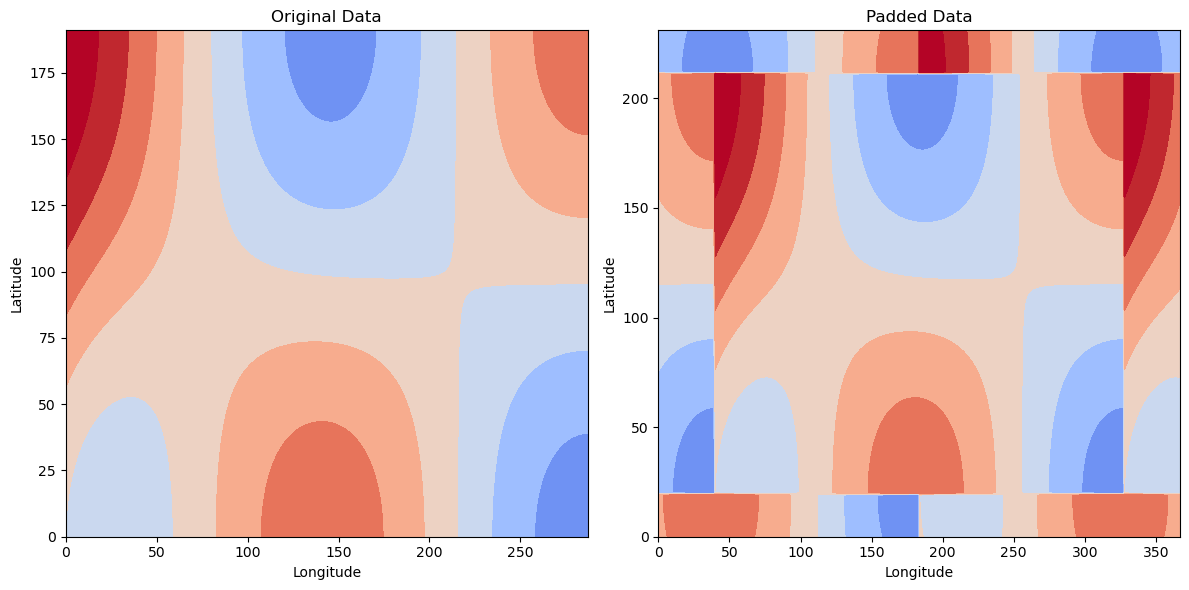

In [170]:
class PeriodicLon_RotRefLat(torch.nn.Module):
    def __init__(self, N_S=40, E_W=80):
        super(PeriodicLon_RotRefLat, self).__init__()
        # Compute padding based on the kernel size (integer division for "same" padding)
        self.paddingNS = N_S // 2
        self.paddingEW = E_W // 2

    def forward(self, x):
        # x shape is [batch, variable, latitude, longitude]
        # roll and reflect latitude

        if self.paddingNS > 0:
            xroll = torch.roll(
                x, shifts=x.shape[3] // 2, dims=3
            )  # 180-degree shift (half the longitude size)
            xroll_flip_top = torch.flip(xroll[:, :, : self.paddingNS, :], (2,))
            xroll_flip_bot = torch.flip(xroll[:, :, -self.paddingNS :, :], (2,))
            x = torch.cat([xroll_flip_top, x, xroll_flip_bot], dim=-2)

        # Circular lon
        x = F.pad(
            x, (self.paddingEW, self.paddingEW, 0, 0), mode="circular"
        )  # Pad last dimension (longitude) by self.padding
        return x


# Original data (torch tensor)
lat = torch.linspace(-90, 90, steps=192)  # 10 latitude points
lon = torch.linspace(0, 360, steps=288)  # 20 longitude points

# Create a grid of values (for demonstration, we'll use a simple mesh grid)
x, y = torch.meshgrid(lat, lon)
z = torch.sin(torch.deg2rad(x)) * torch.cos(torch.deg2rad(y)) + torch.exp(
    -torch.deg2rad(y)
)

# Reshape z to be 4D: (batch, channels, height, width)
z = z.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
P_RR = PeriodicLon_RotRefLat(N_S=40, E_W=80)
zb = P_RR(z)

# Plot the original and padded data
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(12, 6))

# Original data
ax1.set_title("Original Data")
ax1.contourf(z.squeeze().numpy(), cmap="coolwarm", vmin=-1.5, vmax=1.5)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")

# Padded data
ax3.set_title("Padded Data")
cc = ax3.contourf(zb.squeeze().numpy(), cmap="coolwarm", vmin=-1.5, vmax=1.5)
ax3.set_xlabel("Longitude")
ax3.set_ylabel("Latitude")
# plt.colorbar(cc)
plt.tight_layout()
plt.show()

## Test with ERA5

In [173]:
import xarray as xr

In [174]:
DS = xr.open_dataset(
    "/glade/derecho/scratch/wchapman/CESM_LE2_vars/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.cam.h0.PS.PRECT.TREFHT.187001-187912.nc"
)

In [195]:
z.shape

torch.Size([1, 10, 192, 288])

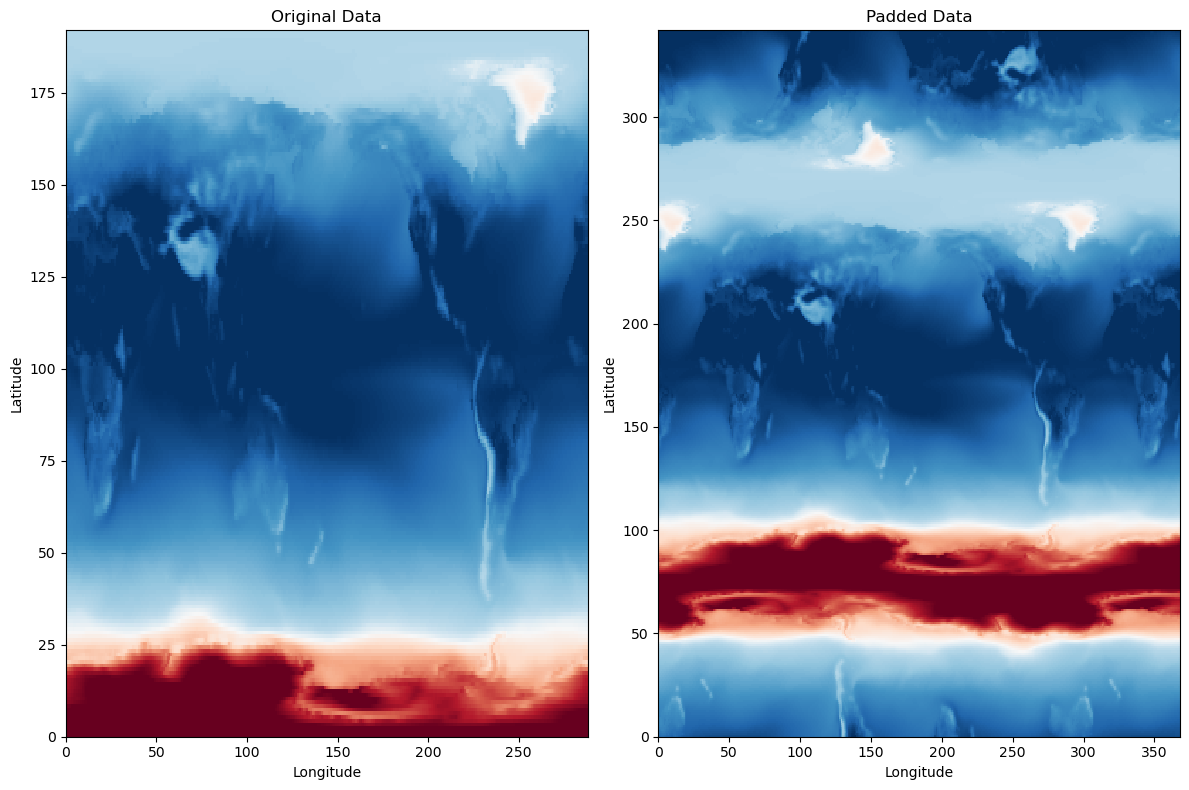

In [197]:
npps = DS["TREFHT"].isel(time=slice(10, 20)).values

# Reshape z to be 4D: (batch, channels, height, width)
z = torch.tensor(npps).unsqueeze(0)  # Add batch and channel dimensions
P_RR = PeriodicLon_RotRefLat(N_S=150, E_W=80)
zb = P_RR(z)

# Plot the original and padded data
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(12, 8))

# Original data
ax1.set_title("Original Data")
ax1.pcolor(z[0, 9, :, :].squeeze().numpy(), cmap="RdBu", vmin=220, vmax=300)
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")

# Padded data
ax3.set_title("Padded Data")
cc = ax3.pcolor(zb[0, 9, :, :].squeeze().numpy(), cmap="RdBu", vmin=220, vmax=300)
ax3.set_xlabel("Longitude")
ax3.set_ylabel("Latitude")
# plt.colorbar(cc)
plt.tight_layout()
plt.show()

In [128]:
zroll = torch.roll(
    z, shifts=z.shape[3] // 2, dims=3
)  # 180-degree shift (half the longitude size)
zpend_top = torch.flip(zroll[:, :, :3, :], (2,))
zpend_bot = torch.flip(zroll[:, :, -3:, :], (2,))
zall = torch.cat([zpend_top, z, zpend_bot], dim=-2)

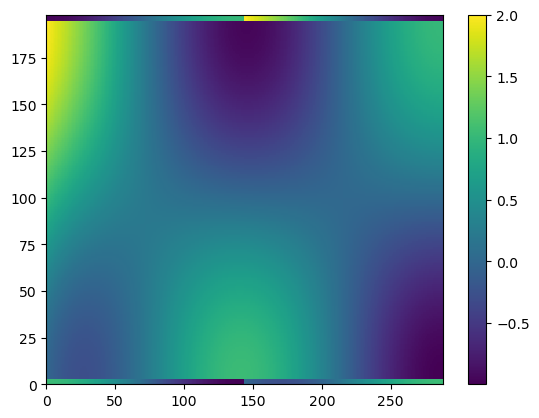

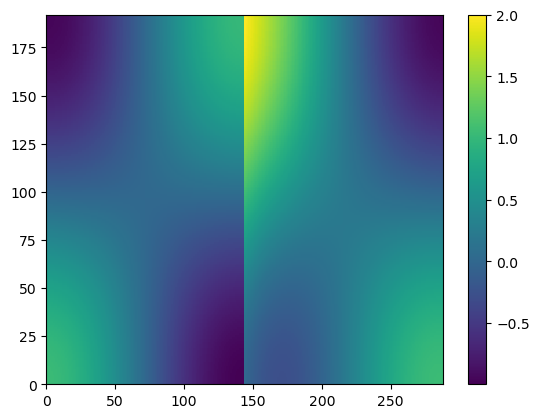

In [129]:
plt.pcolor(zall.squeeze())
plt.colorbar()
plt.show()
plt.pcolor(zroll.squeeze())
plt.colorbar()
plt.show()

In [84]:
zpend_top.shape

torch.Size([192, 3])

In [85]:
zpend_bot.shape

torch.Size([192, 3])

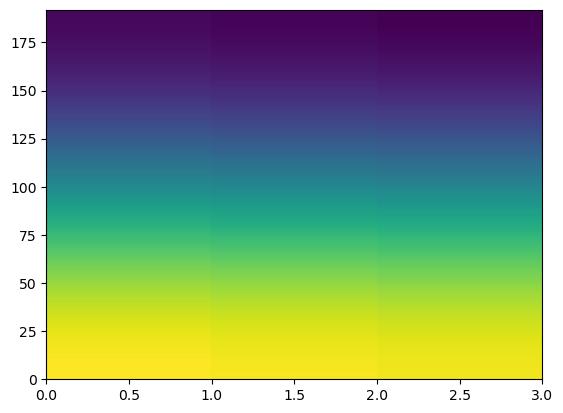

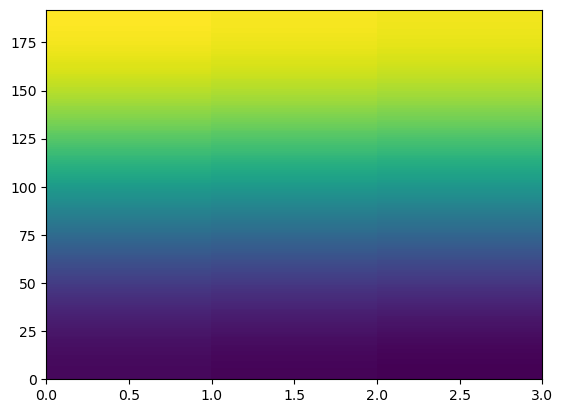

In [78]:
zroll = torch.roll(
    z, shifts=z.shape[1] // 2, dims=1
)  # 180-degree shift (half the longitude size)
zpend = torch.flip(zroll[:, :, :, :3], (2,)).squeeze()

plt.pcolor(torch.flip(zroll[:, :, :, :3], (2,)).squeeze())
plt.show()

plt.pcolor(zroll[:, :, :, :3].squeeze())
plt.show()

zpend = torch.flip(zroll[:, :, :, :3], (2,)).squeeze()


# torch.cat([x[..., -pad:], x, x[..., :pad]], dim=-1)

In [87]:
# Original data (torch tensor)
lat = torch.linspace(-90, 90, steps=10)  # 10 latitude points
lon = torch.linspace(0, 360, steps=20)  # 20 longitude points

# Create a grid of values (for demonstration, we'll use a simple mesh grid)
x, y = torch.meshgrid(lat, lon)
z = torch.sin(torch.deg2rad(x)) * torch.cos(torch.deg2rad(y)) + torch.exp(
    -torch.deg2rad(y)
)

# Reshape z to be 4D: (batch, channels, height, width)
z = z.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions

# Define padding amounts
pad_lat = 2  # Padding for latitude (reflective padding)
pad_lon = 2  # Padding for longitude (circular padding)

print(z.shape)

# Step 1: Rotate the tensor by 180 degrees along the longitude axis to introduce the shift
z = torch.roll(
    z, shifts=z.shape[-1] // 2, dims=-1
)  # 180-degree shift (half the longitude size)

# Step 3: Apply reflective padding for the latitudinal dimension
z_padded = F.pad(z_padded, (0, 0, pad_lat, pad_lat), mode="reflect")

# Step 2: Apply circular padding for the longitudinal dimension
z_padded = circular_pad1d(z, pad=pad_lon)

# Undo the shift
z_final = torch.roll(z_padded, shifts=-z.shape[-1] // 2, dims=-1)  # Undo the shift

# Remove batch and channel dimensions for visualization
z_padded = z_padded.squeeze(0).squeeze(0)

# Original lat/lon values
lat_step = lat[1] - lat[0]  # Get latitude step size
lon_step = lon[1] - lon[0]  # Get longitude step size

# Adjust padded latitude and longitude ranges
padded_lat = torch.linspace(
    lat[0] - pad_lat * lat_step, lat[-1] + pad_lat * lat_step, steps=z_padded.shape[0]
)
padded_lon = torch.linspace(
    lon[0] - pad_lon * lon_step, lon[-1] + pad_lon * lon_step, steps=z_padded.shape[1]
)

torch.Size([1, 1, 10, 20])


NotImplementedError: Only 2D, 3D, 4D, 5D padding with non-constant padding are supported for now

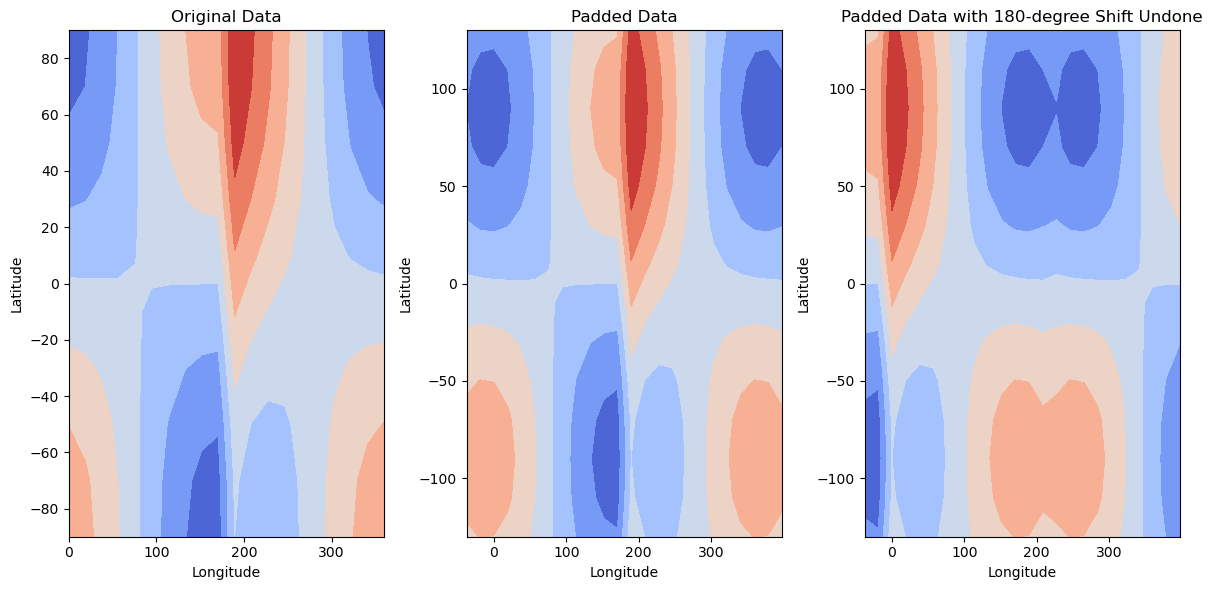

In [84]:
# Plot the original and padded data
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))

# Original data
ax1.set_title("Original Data")
ax1.contourf(lon.numpy(), lat.numpy(), z.squeeze().numpy(), cmap="coolwarm")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")

# Padded data
ax2.set_title("Padded Data")
ax2.contourf(padded_lon.numpy(), padded_lat.numpy(), z_padded.numpy(), cmap="coolwarm")
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")

# Padded data with 180-degree shift undone
ax3.set_title("Padded Data with 180-degree Shift Undone")
ax3.contourf(
    padded_lon.numpy(),
    padded_lat.numpy(),
    z_final.squeeze(0).squeeze(0).numpy(),
    cmap="coolwarm",
)  # Plot after padding
ax3.set_xlabel("Longitude")
ax3.set_ylabel("Latitude")

plt.tight_layout()
plt.show()

### Version 2

In [77]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon
from shapely.prepared import prep

# Grid resolution
lat = torch.linspace(-90, 90, steps=180)  # 180 latitude points (1-degree resolution)
lon = torch.linspace(-180, 180, steps=360)  # 360 longitude points (1-degree resolution)

# Create meshgrid for lat/lon
lon_grid, lat_grid = torch.meshgrid(lon, lat, indexing="xy")

# Convert to numpy arrays for easier use with Shapely
lon_grid_np = lon_grid.numpy()
lat_grid_np = lat_grid.numpy()

# Create a binary mask of coastlines
coastline_mask = np.zeros(lat_grid_np.shape, dtype=np.float32)

# Load the land geometries from Natural Earth
land_feature = cfeature.NaturalEarthFeature("physical", "land", "110m")

# Iterate through the geometries and rasterize them
for geom in land_feature.geometries():
    # Handle MultiPolygon and Polygon geometries
    if isinstance(geom, (Polygon, MultiPolygon)):
        # Prepare the geometry for faster "contains" checks
        prepared_geom = prep(geom)

        # For each grid point, check if it's inside the polygon
        for i in range(lat_grid_np.shape[0]):
            for j in range(lon_grid_np.shape[1]):
                if prepared_geom.contains(
                    Polygon([(lon_grid_np[i, j], lat_grid_np[i, j])])
                ):
                    coastline_mask[i, j] = 1  # Mark as coastline

# Convert the binary coastline mask to a torch tensor
z = torch.tensor(coastline_mask)

# Reshape z to be 4D: (batch, channels, height (lat), width (lon))
z = z.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions (B, C, lat, lon)

# Define padding amounts
pad_lat = 10  # Padding for latitude (reflective padding)
pad_lon = 10  # Padding for longitude (circular padding)


# Circular padding for longitude (wrap around)
def circular_pad1d(x, pad):
    return torch.cat([x[..., -pad:], x, x[..., :pad]], dim=-1)


# Step 1: Rotate the tensor by 180 degrees along the longitude axis to introduce the shift
z = torch.roll(
    z, shifts=z.shape[-1] // 2, dims=-1
)  # 180-degree shift (half the longitude size)

# Step 2: Apply circular padding for the longitudinal dimension
z_padded = circular_pad1d(z, pad=pad_lon)

# Step 3: Apply reflective padding for the latitudinal dimension
z_padded = F.pad(z_padded, (0, 0, pad_lat, pad_lat), mode="reflect")

# Step 4: Undo the 180-degree shift
z_final = torch.roll(z_padded, shifts=-z.shape[-1] // 2, dims=-1)  # Undo the shift

# Original lat/lon values
lat_step = lat[1] - lat[0]  # Get latitude step size
lon_step = lon[1] - lon[0]  # Get longitude step size

# Adjust padded latitude and longitude ranges
padded_lat = torch.linspace(lat[0] - pad_lat, lat[-1] + pad_lat, steps=z_final.shape[2])
padded_lon = torch.linspace(lon[0] - pad_lon, lon[-1] + pad_lon, steps=z_final.shape[3])

# Plot the original and padded data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Original binary mask
ax1.set_title("Original Coastline Mask")
ax1.contourf(
    lon.numpy(), lat.numpy(), z.squeeze(0).squeeze(0).numpy(), cmap="gray"
)  # Plot before padding
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")

# Padded binary mask
ax2.set_title("Padded Coastline Mask with 180-degree Shift Undone")
ax2.contourf(
    padded_lon.numpy(),
    padded_lat.numpy(),
    z_final.squeeze(0).squeeze(0).numpy(),
    cmap="gray",
)  # Plot after padding
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")

plt.tight_layout()
plt.show()

ValueError: A linearring requires at least 4 coordinates.